In [4]:

import pandas as pd
import numpy as np
import json
import os
from pathlib import Path

from collections import defaultdict
#from pathlib import Path
import matplotlib.pyplot as plt
#import seaborn as sns
#from scipy import stats
#from sklearn.metrics import r2_score
#from scipy.optimize import curve_fit
#from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

# Configuration
SAVE_DIR = "Saved_files_new/"


In [17]:

def normalize_term(term: str) -> str:
    """Normalize term: lowercase and remove spaces"""
    return term.strip().lower().replace(' ', '').replace('-', '')

def find_exact_software_matches(term: str, software_list):
    """
    Find exact matches allowing only case differences and spaces.
    
    Args:
        term: Term to match
        software_list: List of software names
    
    Returns:
        List of matched software names (original case)
    """
    term_norm = normalize_term(term)
    matches = []
    
    for software in software_list:
        software_norm = normalize_term(software)
        if term_norm == software_norm:
            matches.append(software)
    
    return matches

def count_software_frequencies_exact(frequencies_dict: dict, software_list, debug: bool = False):
    """
    Count software frequencies using exact matching (case/space insensitive only).
    """
    software_counts = defaultdict(int)
    matched_terms = defaultdict(list)
    
    if debug:
        print("🔍 Processing terms with exact matching (case/space insensitive)...")
    
    for category in ['keywords', 'bigrams', 'trigrams']:
        freq_dict = frequencies_dict.get(category, {})
        if not freq_dict:
            continue
            
        if debug:
            print(f"\n--- Processing {category} ({len(freq_dict)} terms) ---")
        
        for term, count in freq_dict.items():
            matches = find_exact_software_matches(term, software_list)
            
            for software in matches:
                software_counts[software] += count
                matched_terms[software].append((term, count))
                
                if debug:
                    print(f"  ✅ '{term}' ({count}x) -> {software}")
    
    return dict(software_counts), dict(matched_terms)

def plot_software_frequencies_exact(
    filename: str,
    software_list=None,
    n_terms: int = 15,
    save: bool = False,
    save_dir: str = ".",
    show_details: bool = True,
    debug: bool = False
):
    """
    Plot software frequencies using exact matching (case and space insensitive only).
    
    Args:
        filename: JSON file with term frequencies
        software_list: List of software names to match
        n_terms: Number of top terms to show
        save: Whether to save outputs
        save_dir: Directory for saving
        show_details: Show detailed matching info
        debug: Print debug information during matching
    """
    if software_list is None:
        software_list = SOFTWARE_NAMES
    
    if not filename:
        print("❌ No filename provided")
        return
    
    # Find file
    file_prefix = filename.replace('.json', '')
    candidates = [
        os.path.join(save_dir, filename),
        os.path.join(save_dir, f"{filename}.json") if not filename.endswith('.json') else os.path.join(save_dir, filename)
    ]
    filepath = next((p for p in candidates if os.path.exists(p)), None)
    
    if filepath is None:
        print(f"❌ File not found: {filename}")
        try:
            json_files = [f for f in os.listdir(save_dir) if f.endswith('.json')]
            print(f"📁 Available files: {', '.join(sorted(json_files))}")
        except:
            pass
        return
    
    # Load frequencies
    print(f"📈 Loading: {os.path.basename(filepath)}")
    print(f"🎯 Exact matching only (case/space insensitive)")
    print(f"🔧 Software targets: {len(software_list)}")
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            frequencies = json.load(f)
    except Exception as e:
        print(f"❌ Load error: {e}")
        return
    
    # Count with exact matching
    software_counts, matched_terms = count_software_frequencies_exact(
        frequencies, software_list, debug=debug
    )
    
    if not software_counts:
        print("❌ No exact matches found")
        print("💡 Check your software list or frequency data")
        return
    
    # Plot results
    ranked = sorted(software_counts.items(), key=lambda x: x[1], reverse=True)
    top = ranked[:n_terms]
    labels = [k for k, _ in top]
    values = [v for _, v in top]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    bars = ax.barh(labels[::-1], values[::-1], color='steelblue', alpha=0.75)
    
    ax.set_title(f"Software Tools - Exact Matching (Case/Space Insensitive)", fontweight='bold', fontsize=14)
    ax.set_xlabel("Total Occurrences", fontsize=12)
    ax.invert_yaxis()
    
    # Add count labels
    for bar, count in zip(bars, values[::-1]):
        ax.text(bar.get_width() + 0.01 * max(values), bar.get_y() + bar.get_height()/2,
                str(count), ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    
    if save:
        output_pfd = os.path.join(save_dir, f"{file_prefix}_software_exact.pdf")
        plt.savefig(output_pdf, dpi=300, bbox_inches='tight')
        print(f"💾 Plot saved: {output_pdf}")
    
    plt.show()
    
    # Show details
    if show_details:
        print(f"\n📊 Found {len(software_counts)} software tools:")
        print("=" * 60)
        
        for software, total in ranked:
            print(f"\n🔧 {software}: {total} occurrences")
            if software in matched_terms:
                print("   Matched terms:")
                for term, count in sorted(matched_terms[software], key=lambda x: x[1], reverse=True)[:5]:
                    print(f"      • '{term}' ({count}x)")
                remaining = len(matched_terms[software]) - 5
                if remaining > 0:
                    print(f"      ... and {remaining} more")
    
    # Save detailed CSV
    if save:
        rows = []
        for software, total in ranked:
            for term, count in matched_terms.get(software, []):
                rows.append({
                    "software": software,
                    "total_count": total,
                    "matched_term": term,
                    "term_count": count
                })
        
        if rows:
            df = pd.DataFrame(rows)
            output_csv = os.path.join(save_dir, f"{file_prefix}_software_exact.csv")
            df.to_csv(output_csv, index=False)
            print(f"💾 Details saved: {output_csv}")
    
    return software_counts, matched_terms

# Test function
def test_exact_matching(test_terms=None, software_list=None):
    """Test the exact matching function with example terms."""
    if software_list is None:
        software_list = SOFTWARE_NAMES[:10]  # Just first 10 for testing
    
    if test_terms is None:
        test_terms = [
            'Python', 'python', 'PYTHON',        # Should all match Python
            'MATLAB', 'matlab', 'Matlab',        # Should all match MATLAB
            'R', 'r',                            # Should match R
            'Excel', 'excel', 'EXCEL',           # Should match Excel
            'Power BI', 'power bi', 'powerbi', 'POWERBI',  # Test Power BI variations
            'VS Code', 'vs code', 'vscode',      # Test VS Code variations
            'TensorFlow', 'tensorflow', 'tensor flow',  # Test TensorFlow
            'power', 'matlab_toolbox', 'irrelevant'     # Should NOT match
        ]
    
    print("🧪 Testing exact matching (case/space insensitive):")
    print("=" * 60)
    
    for term in test_terms:
        print(f"\nTerm: '{term}'")
        matches = find_exact_software_matches(term, software_list)
        if matches:
            for software in matches:
                print(f"  ✅ {software}")
        else:
            print(f"  ❌ No matches")


## Method Implementation Level Score plotting functions

In [19]:
def plot_top_methods_by_MIS(mis_row, top_k=25, save_path=None):
    """Plot top methods by MIS - no changes needed (independent of GGT trends)"""
    mis_sorted = mis_row.dropna().sort_values(ascending=False).head(top_k)
    plt.figure(figsize=(10, max(4, 0.35*len(mis_sorted))))
    sns.barplot(x=mis_sorted.values, y=mis_sorted.index, color="#4C78A8")
    plt.xlabel("Method Implementation Level Score (MILS)")
    plt.ylabel("Method")
    plt.title("Top methods by MILS")
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print(f"Saved: {save_path}")
    plt.show()

# plot OSMM scores 
def plot_software_scores(df, figsize=(14,8)):
    from adjustText import adjust_text
    metadata_cols=['Include?', 'Vendor', 'Type', 'Coverage', 'Type of modelling']
    method_cols = [col for col in df.columns if col not in metadata_cols and not col.startswith('OSMM')]

    df_methods=df[method_cols].apply(pd.to_numeric,errors='coerce')
    if 'Avg_method_rank' not in method_cols: 
        df['Avg_method_rank']= df_methods.mean(axis=1, skipna=True)
    

    # Create color mapping for Type
    unique_types = df['Type'].dropna().unique()
    colors = plt.cm.tab10(range(len(unique_types)))  # Use tab10 colormap
    color_map = dict(zip(unique_types, colors))
    
    # Assign colors to each row based on Type
    point_colors = [color_map.get(t, 'gray') for t in df['Type']]

    # Calculate number of methods with rank > 2 for each software
    if 'Methods_rank_sum' not in df.columns:
        df['Methods_rank_sum'] = (df_methods).sum(axis=1)
    # Scale the sizes (adjust multiplier as needed)
    sizes =50+df['Methods_rank_sum']*2  # Base size 50, +10 per method above 2

    #Scatter plot
    plt.figure(figsize=figsize)
    plt.scatter(df['OSMM Score'],df['Avg_method_rank'], s=sizes, c = point_colors,alpha=0.6,edgecolors='black',linewidths=1)


    for i, (idx, row) in enumerate(df.iterrows()):
        if  i%2==0:
            xytext=(5,-5)
            ha='right'
        else:
            xytext=(5,5)
            ha='left'
        plt.annotate(idx, # software name (index col)
                     (row['OSMM Score'],row['Avg_method_rank']), #xy coordinates for the point beeing annotated
                     fontsize=8,
                     #ha=ha,
                     #xytext=xytext,textcoords='offset points', # text position relative to point and type of offset
                     bbox = dict(boxstyle='round,pad=0.3', 
                                facecolor='none',
                                alpha=0.3))

    plt.xlabel('OSMM Score', fontsize=12, fontweight='bold')
    plt.xlabel('OSMM Score', fontsize=12, fontweight='bold')
    plt.ylabel('Average Method Implementation Rank', fontsize=12, fontweight='bold')
    plt.title('OSMM Score vs Average Method Implementation Rank for Each Software', 
         fontsize=14, fontweight='bold', pad=20)
    # Create legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor=color_map[t], markersize=10,
                                  label=t) for t in unique_types]
    plt.legend(handles=legend_elements, title='Type', loc='best')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

def plot_software_scores_interactive(df, figsize=(14,8)):
    import mplcursors  # Install with: pip install mplcursors
    
    metadata_cols=['Include?', 'Vendor', 'Type', 'Coverage', 'Type of modelling']
    method_cols = [col for col in df.columns if col not in metadata_cols and not col.startswith('OSMM')]

    df_methods=df[method_cols].apply(pd.to_numeric,errors='coerce')
    if 'Avg_method_rank' not in method_cols: 
        df['Avg_method_rank']= df_methods.mean(axis=1, skipna=True)

    # Create color mapping for Type
    unique_types = df['Type'].dropna().unique()
    colors = plt.cm.tab10(range(len(unique_types)))
    color_map = dict(zip(unique_types, colors))
    
    point_colors = [color_map.get(t, 'gray') for t in df['Type']]

    # Calculate sizes
    df['Methods_above_1'] = (df_methods > 1).sum(axis=1)
    sizes = df['Methods_above_1'] * 10 + 50

    # Scatter plot
    fig, ax = plt.subplots(figsize=figsize)
    scatter = ax.scatter(df['OSMM Score'], df['Avg_method_rank'], s=sizes, c=point_colors,
                        alpha=0.6, edgecolors='black', linewidths=1)
    
    # Add interactive cursor
    cursor = mplcursors.cursor(scatter, hover=True)
    @cursor.connect("add")
    def on_add(sel):
        idx = sel.index
        software_name = df.index[idx]
        sel.annotation.set_text(software_name)
        sel.annotation.get_bbox_patch().set(fc="white", alpha=0.9)
    
    ax.set_xlabel('OSMM Score', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Method Implementation Rank', fontsize=12, fontweight='bold')
    ax.set_title('OSMM Score vs Average Method Implementation Rank (Hover for labels)', 
                fontsize=14, fontweight='bold', pad=20)
    
    # Legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor=color_map[t], markersize=10,
                                  label=t) for t in unique_types]
    ax.legend(handles=legend_elements, title='Type', loc='upper left')
    
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()


def pick_top_softwares(df_full_no_mis, df_full_with_mis, methods_for_heat, top_sw=12, 
                      prod_prefix="OSMM - product maturity"):
    """Pick top softwares - no changes needed (independent of GGT trends)"""
    prod_cols = [c for c in df_full_with_mis.columns if c.strip().startswith(prod_prefix)]
    if prod_cols:
        sw_score = df_full_no_mis[prod_cols].mean(axis=1, skipna=True)
        sw_pick = sw_score.sort_values(ascending=False).head(top_sw).index
    else:
        sub = df_full_no_mis[methods_for_heat]
        sw_pick = sub.mean(axis=1, skipna=True).sort_values(ascending=False).head(top_sw).index
    return sw_pick


def plot_implementation_heatmap(df_wo_mis, mis_row, top_methods=20, top_softwares=12, 
                               save_path=None):
    """Plot implementation heatmap - no changes needed"""
    heat_methods = mis_row.dropna().sort_values(ascending=False).head(top_methods).index.tolist()
    sub = df_wo_mis[heat_methods].copy()
    sw_pick = pick_top_softwares(df_wo_mis, df_mis, heat_methods, top_sw=top_softwares)
    heat = sub.loc[sw_pick]

    plt.figure(figsize=(1.2*len(heat.columns)+3, 0.5*len(heat.index)+2))
    sns.heatmap(heat, cmap="YlGnBu", annot=False, cbar_kws={"label": "Implementation rank (0–3)"})
    plt.title("Implementation rank heatmap (top softwares × top MIS methods)")
    plt.xlabel("Method")
    plt.ylabel("Software")
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print(f"Saved: {save_path}")
    plt.show()


### Data loading

In [20]:
# loading analysis data
date_string = "2025_10_29_reliability_resilience_power_systems" 
data = setup_analysis_data(date_string)

if data is None:
    print("❌ Cannot proceed without data. Please check your file paths and naming.")
else:
    df = data['df']
    topic_names = data['topic_names']
    term_frequencies_file = data['term_frequencies_file']
    method_cols = data['method_cols']
    topic_specific_tfidf_ngrams = data['topic_specific_tfidf_ngrams']
    print("✅ Data setup complete! Ready for visualization.")

🔍 LOADING ANALYSIS DATA
Loading complete analysis data for 2025_10_29_reliability_resilience_power_systems...
Searching in directory: Saved_files_new
  Checking for main analysis file...
  ✅ Found: enhanced_method_analysis_2025_10_29_reliability_resilience_power_systems.csv
  ✅ Loaded DataFrame: (30917, 39)
  📊 Columns: ['paperId', 'title', 'abstract', 'venue', 'year', 'citationCount', 'fieldsOfStudy', 'authors', 'openAccessPdf', 'text', 'processed_text', 'Primary_Topic_Index', 'Primary_Score', 'Dominance_Ratio', 'Primary_Topic', 'Method_1', 'Method_1_Score', 'Method_2', 'Method_2_Score', 'Method_3', 'Method_3_Score', 'Method_4', 'Method_4_Score', 'Method_5', 'Method_5_Score', 'Method_6', 'Method_6_Score', 'Method_7', 'Method_7_Score', 'Method_8', 'Method_8_Score', 'Method_9', 'Method_9_Score', 'Method_10', 'Method_10_Score', 'Primary_Method', 'Primary_Method_Score', 'Method_Confidence', 'Total_Method_Score']
  Checking for topic metadata...
  ✅ Found topic file: topics_2025_10_29_reli

In [21]:
filepath=os.path.join(SAVE_DIR, term_frequencies_file)
with open(filepath, 'r', encoding='utf-8') as f:
    frequencies = json.load(f)
count_software_frequencies_exact(frequencies, SOFTWARE_NAMES)


({'Excel': 79,
  'ETAP': 62,
  'Power Factory': 57,
  'OpenDSS': 21,
  'NEPLAN': 16,
  'Power World': 50,
  'PSAT': 13,
  'IPSA': 2,
  'TARA': 2,
  'Spectrum Power': 22},
 {'Excel': [('excel', 79)],
  'ETAP': [('etap', 62)],
  'Power Factory': [('powerfactory', 39), ('power factory', 18)],
  'OpenDSS': [('opendss', 21)],
  'NEPLAN': [('neplan', 16)],
  'Power World': [('powerworld', 16), ('power world', 34)],
  'PSAT': [('psat', 13)],
  'IPSA': [('ipsa', 2)],
  'TARA': [('tara', 2)],
  'Spectrum Power': [('spectrum power', 22)]})

In [22]:
# --------- CONFIG (edit paths) ----------
#COMPLETE_CSV   = "input_data\Software_method_implementation_score.csv"  # your cleaned matrix with MIS as a row#
COMPLETE_CSV   = "software_analysis_output\software_methods_with_mis_updated.csv"
GGT_CSV        = "Saved_files_new/ggt_results_dual.csv"              # method, ggt_corrected_growth, total_importance, (optional) lifecycle_stage
SAVE_DIR       = "Saved_files_new"
SEP            = ";"    # change to "," or "\t" if needed
DECIMAL        = ","    # change to "." if needed
# Non-method prefixes (everything else is treated as a method candidate)
NON_METHOD_PREFIXES = (
    "Software info",
    "OSMM - product maturity",
    "OSMM - industry adoption",
)

# Exact MIS row label (Norwegian)
MIS_ROW_LABEL = "Gjennomsnittlig score (MIS)"
RAW_MIS_ROW_LABEL= "Sum raw implementation score"

# ---------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_context("talk", font_scale=0.9)
sns.set_style("whitegrid")

# 1) Load the complete mapping as-is (no fancy parsing)
df_mis = pd.read_csv(COMPLETE_CSV, sep=SEP, decimal=DECIMAL, encoding="utf-8-sig")

# 2) Make a software identifier index (match any column that contains 'name')
name_col = None
for c in df_mis.columns:
    if "name" in c.strip().lower():  # catches 'Software info-Name' too
        name_col = c
        break

if name_col is not None:
    df_mis = df_mis.set_index(name_col)

# 3) Strip whitespace on headers and index (fix typos: use df_mis, not df)
df_mis.columns = [c.strip() for c in df_mis.columns]
df_mis.index   = df_mis.index.astype(str).str.strip()

# 4) Detect the MIS row and RAW MIS rowby exact label (case-insensitive, trimmed)
#    Use == because Index has no .eq
idx_norm = df_mis.index.astype(str).str.strip().str.casefold()
mis_mask = (idx_norm == MIS_ROW_LABEL.strip().casefold())
raw_mis_mask = (idx_norm == RAW_MIS_ROW_LABEL.strip().casefold())
if not mis_mask.any():
    raise AssertionError(f"MIS row not found. Expected label: '{MIS_ROW_LABEL}'")

# 5) Extract MIS row and drop it from the matrix
mis_row  = df_mis.loc[mis_mask].iloc[0].copy()
raw_mis_row= df_mis.loc[raw_mis_mask].iloc[0].copy()
#remove both MIS rows and raw MIS rows from df_mis
df_wo_mis = df_mis.loc[~(mis_mask | raw_mis_mask)].copy()

# 6) Convert all to numeric once (non-numeric meta columns become NaN)
df_wo_mis = df_wo_mis.apply(pd.to_numeric, errors="coerce")
mis_row   = pd.to_numeric(mis_row, errors="coerce")
raw_mis_row   = pd.to_numeric(raw_mis_row, errors="coerce")

# 7) Identify method columns:
#    - Not starting with any NON_METHOD_PREFIXES (case-insensitive)
#    - Have a non-null MIS value
def starts_with_any_ci(s: str, prefixes) -> bool:
    s_norm = s.strip().casefold()
    return any(s_norm.startswith(p.strip().casefold()) for p in prefixes)

candidate_cols = [c for c in df_mis.columns if not starts_with_any_ci(c, NON_METHOD_PREFIXES)]
method_cols    = [c for c in candidate_cols if c in mis_row.index and pd.notna(mis_row[c])]

# 8) Build the method-only frame
df_methods = df_wo_mis[method_cols].copy()

# Sanity prints
print(f"Loaded matrix shape (with MIS): {df_mis.shape}")
print(f"Software rows (excluding MIS): {df_methods.shape[0]}")
print(f"Method columns detected: {len(method_cols)}")
print(f"First 10 methods: {method_cols[:10]}")
print(f"MIS non-null count: {mis_row.notna().sum()}")



Loaded matrix shape (with MIS): (39, 210)
Software rows (excluding MIS): 37
Method columns detected: 189
First 10 methods: ['power flow analysis', 'security-constrained optimal power flow', 'security constrained unit commitment', 'Non Linear Optimal Power Flow', 'Multi-Period  Optimisation', 'unit commitment', 'genetic algorithm', 'neural network', 'kalman filter', 'monte-carlo']
MIS non-null count: 189


### Category data

## Plotting

📈 Loading: term_frequencies_2025_10_29_reliability_resilience_power_systems.json
🎯 Exact matching only (case/space insensitive)
🔧 Software targets: 50


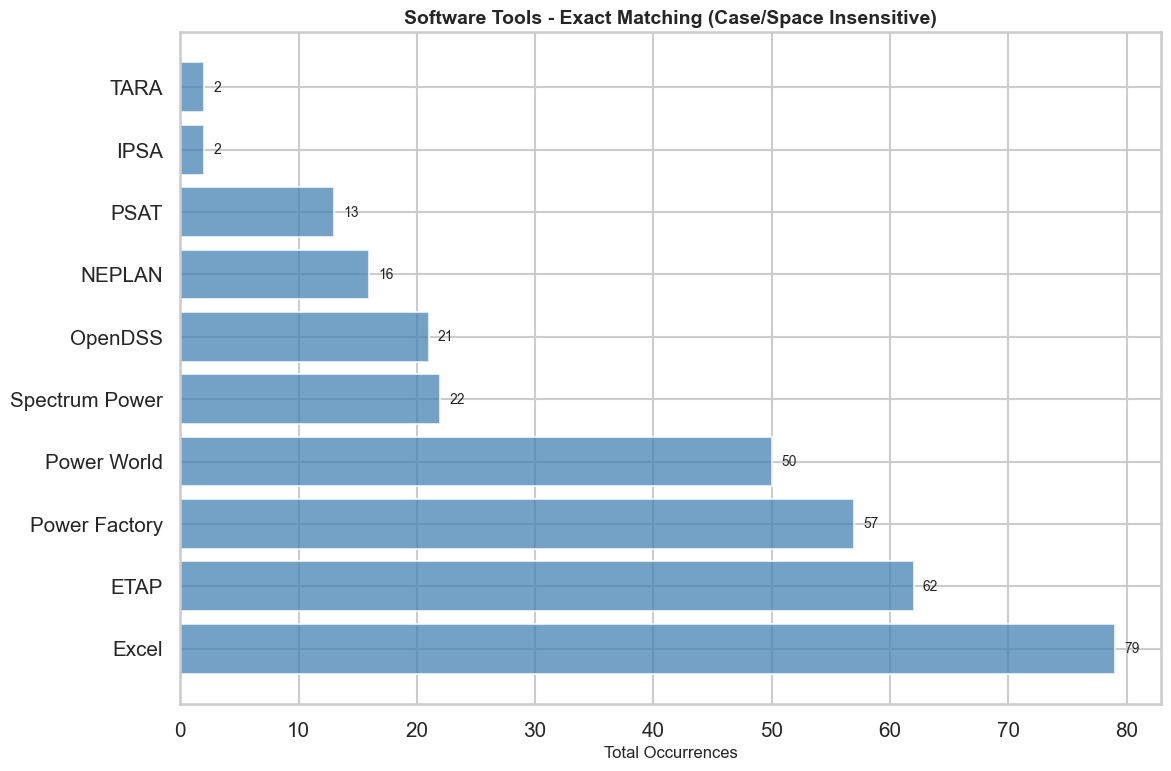


📊 Found 10 software tools:

🔧 Excel: 79 occurrences
   Matched terms:
      • 'excel' (79x)

🔧 ETAP: 62 occurrences
   Matched terms:
      • 'etap' (62x)

🔧 Power Factory: 57 occurrences
   Matched terms:
      • 'powerfactory' (39x)
      • 'power factory' (18x)

🔧 Power World: 50 occurrences
   Matched terms:
      • 'power world' (34x)
      • 'powerworld' (16x)

🔧 Spectrum Power: 22 occurrences
   Matched terms:
      • 'spectrum power' (22x)

🔧 OpenDSS: 21 occurrences
   Matched terms:
      • 'opendss' (21x)

🔧 NEPLAN: 16 occurrences
   Matched terms:
      • 'neplan' (16x)

🔧 PSAT: 13 occurrences
   Matched terms:
      • 'psat' (13x)

🔧 IPSA: 2 occurrences
   Matched terms:
      • 'ipsa' (2x)

🔧 TARA: 2 occurrences
   Matched terms:
      • 'tara' (2x)


({'Excel': 79,
  'ETAP': 62,
  'Power Factory': 57,
  'OpenDSS': 21,
  'NEPLAN': 16,
  'Power World': 50,
  'PSAT': 13,
  'IPSA': 2,
  'TARA': 2,
  'Spectrum Power': 22},
 {'Excel': [('excel', 79)],
  'ETAP': [('etap', 62)],
  'Power Factory': [('powerfactory', 39), ('power factory', 18)],
  'OpenDSS': [('opendss', 21)],
  'NEPLAN': [('neplan', 16)],
  'Power World': [('powerworld', 16), ('power world', 34)],
  'PSAT': [('psat', 13)],
  'IPSA': [('ipsa', 2)],
  'TARA': [('tara', 2)],
  'Spectrum Power': [('spectrum power', 22)]})

In [24]:
plot_software_frequencies_exact(filepath, software_list=SOFTWARE_NAMES)


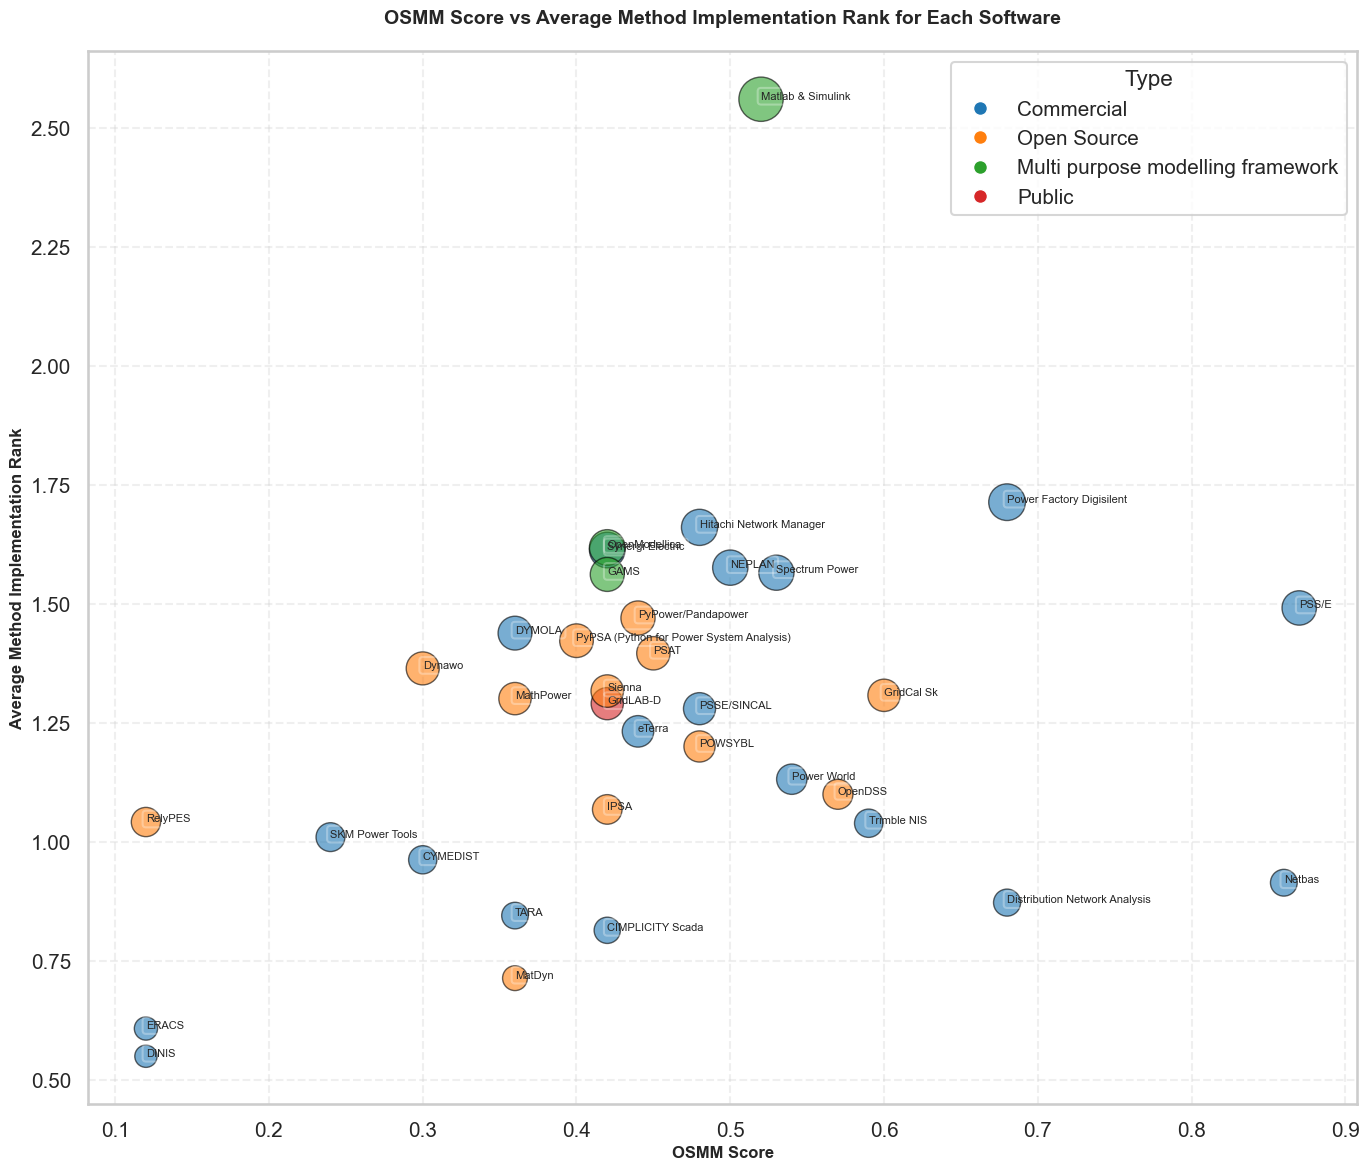

In [25]:
plot_software_scores(df_mis,figsize=(14,12))

Saved: Saved_files_new\top_methods_by_MIS.pdf


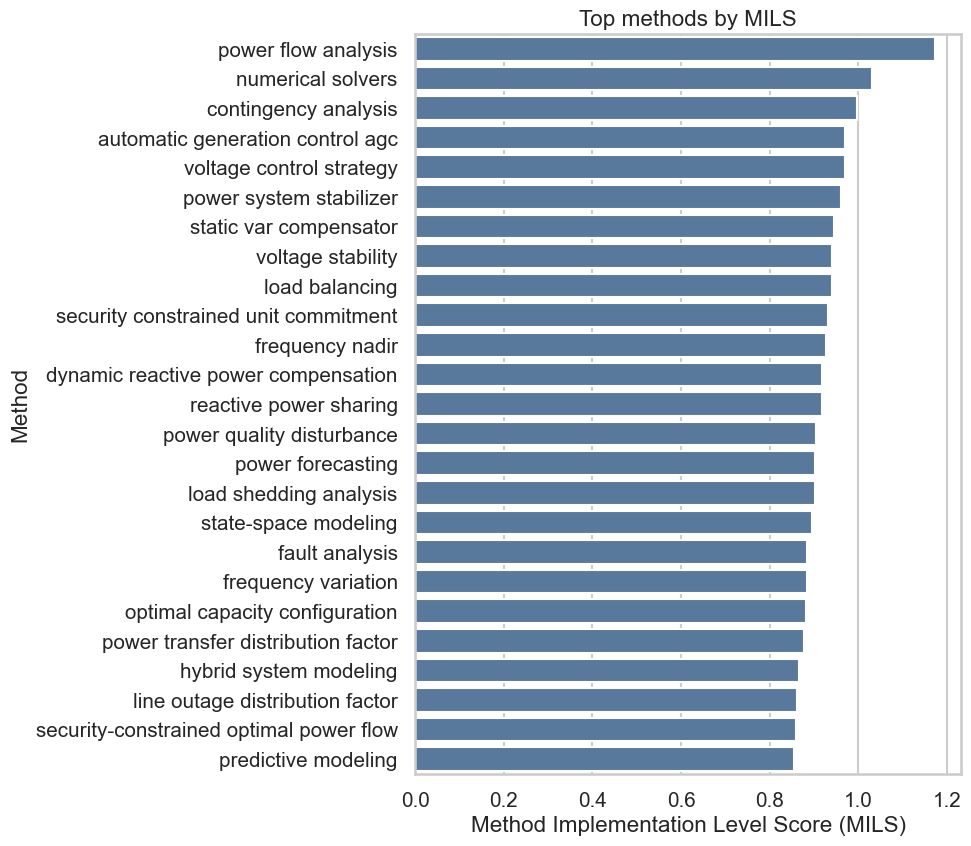

In [26]:
plot_top_methods_by_MIS(
    mis_row,
    top_k=25,
    save_path=Path(SAVE_DIR, "top_methods_by_MIS.pdf")
)


Saved: Saved_files_new\software_heatmap.pdf


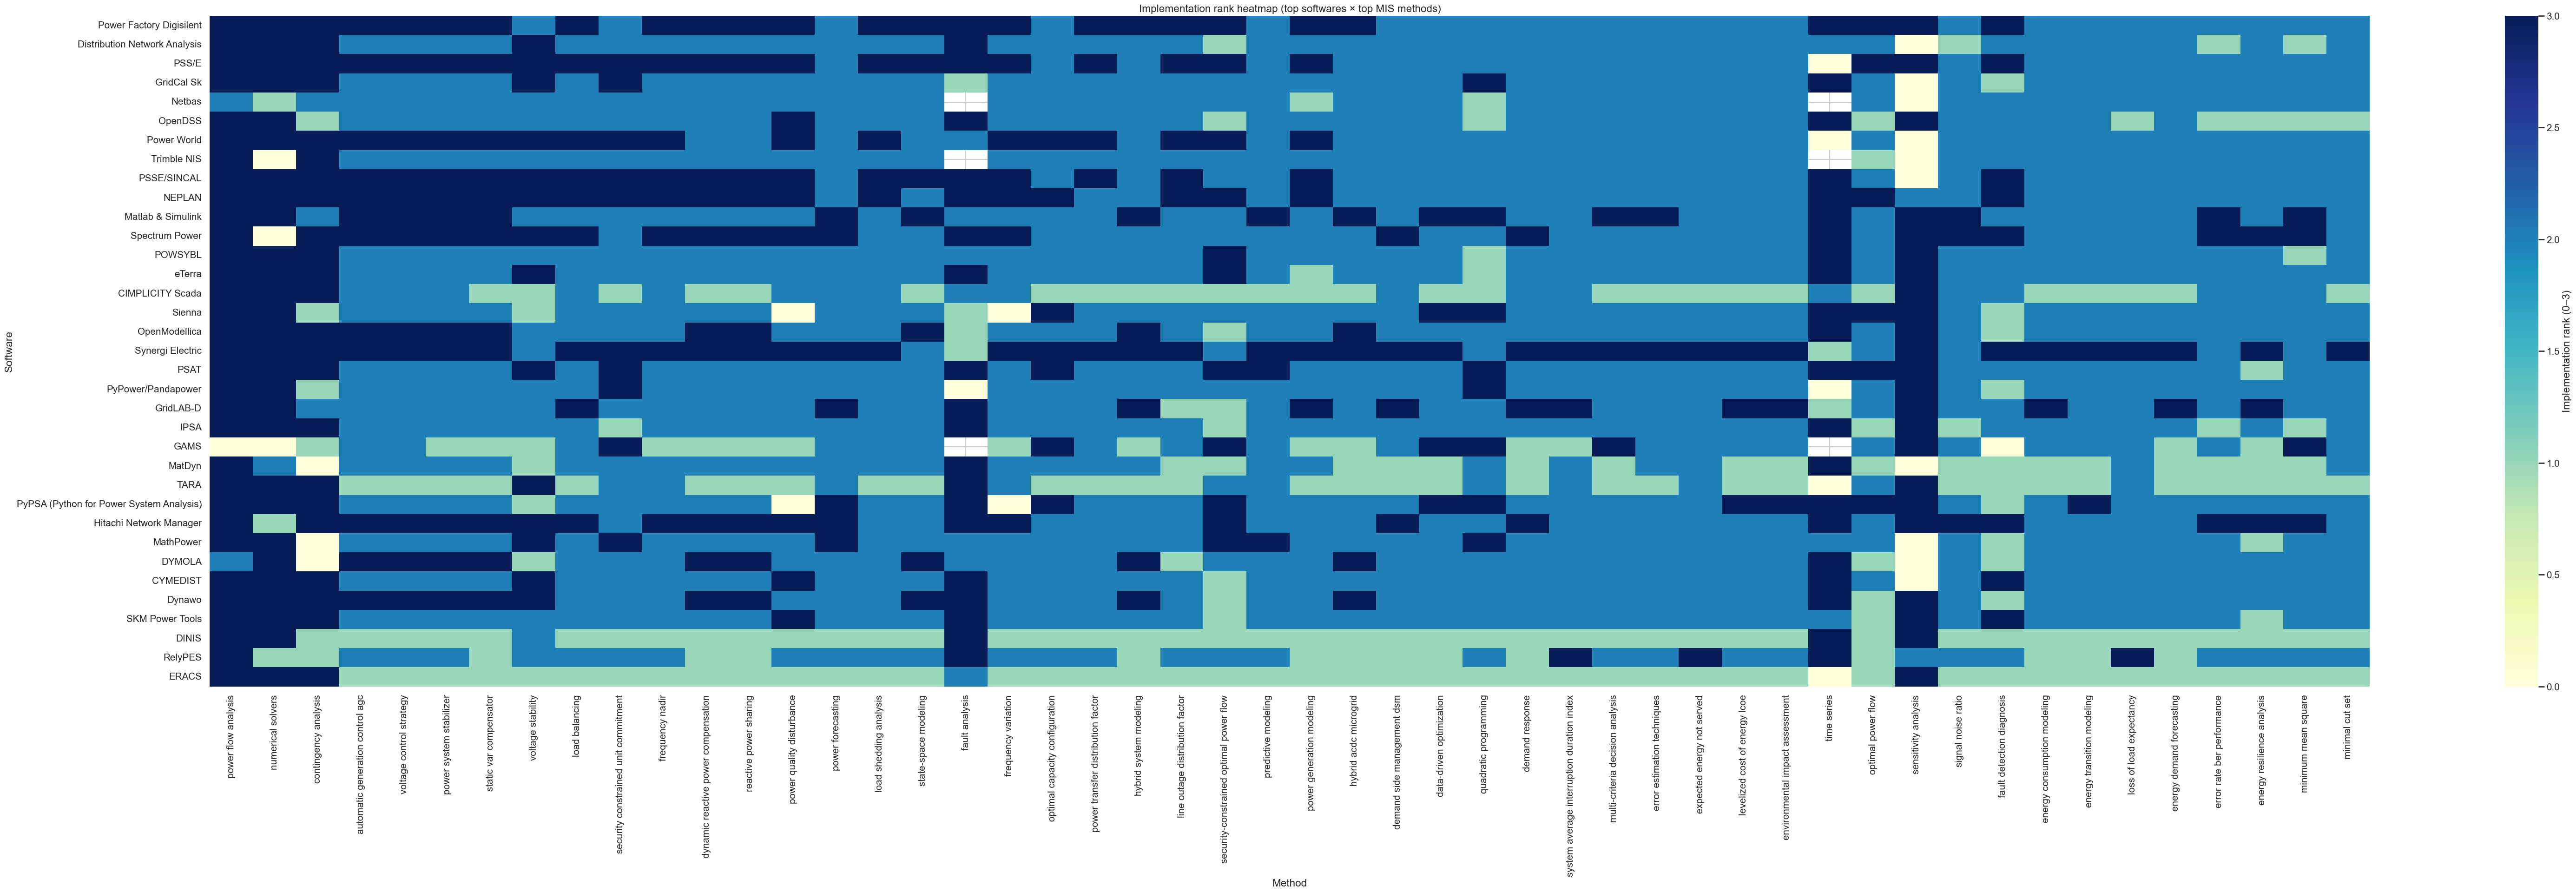

In [27]:
plot_implementation_heatmap(
    df_wo_mis,
    mis_row,
    top_methods=50,
    top_softwares=35,
    save_path=Path(SAVE_DIR, "software_heatmap.pdf")
)
